# References

Kaggle for data: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download and Jeff Prosise: https://github.com/jeffprosise/Deep-Learning/blob/master/Fraud%20Detection.ipynb 

At the end of the Lab, students should be able to

1. Use spaCy to examine PoS tags of a sentence.
2. Perform binary classification using a simple neural network.

In [ ]:
!python -m spacy download sv_core_news_sm

2022-11-08 14:53:25.600310: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.7 MB 4.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('sv_core_news_sm')


In [ ]:
import spacy
from spacy.lang.sv.examples import sentences 

nlp = spacy.load("sv_core_news_sm")
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple överväger att köpa brittisk startup för 1 miljard dollar.
Apple PROPN nsubj
överväger VERB ROOT
att PART mark
köpa VERB xcomp
brittisk ADJ amod
startup NOUN obj
för ADP case
1 NUM nummod
miljard NOUN amod
dollar VERB parataxis
. PUNCT punct


Binary Classification example using creditcard dataset:

In [ ]:
import pandas as pd

df = pd.read_csv('creditcard.csv')
df = df.dropna()
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

x = df.drop(['Time', 'Class'], axis=1)    # drop these 2 columns
y = df['Class']                           # assign labels to y

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

For an example diagram of a neural network, see https://www.v7labs.com/blog/neural-network-architectures-guide 




In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(128, activation='relu', input_dim=29))    # Activation function defines the output of that node given an input or set of inputs
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) # Optimizer is an algorithm that modifies the attributes of the neural network, such as weights and learning rate, to reduce the loss and improve the accuracy
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               3840      
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100)

Epoch 1/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0256 - accuracy: 0.9966 - val_loss: 0.0064 - val_accuracy: 0.9994
Epoch 2/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0072 - accuracy: 0.9993 - val_loss: 0.0058 - val_accuracy: 0.9994
Epoch 3/10
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0154 - accuracy: 0.9993 - val_loss: 0.0072 - val_accuracy: 0.9993
Epoch 4/10
2279/2279 [==============================] - 6s 3ms/step - loss: 0.0067 - accuracy: 0.9994 - val_loss: 0.0050 - val_accuracy: 0.9993
Epoch 5/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0071 - accuracy: 0.9994 - val_loss: 0.0042 - val_accuracy: 0.9994
Epoch 6/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0094 - accuracy: 0.9994 - val_loss: 0.0041 - val_accuracy: 0.9995
Epoch 7/10
2279/2279 [==============================] - 5s 2ms/step - loss: 0.0072 - accuracy: 0.9993 - val_loss: 0.0093 - val_accuracy:

[]

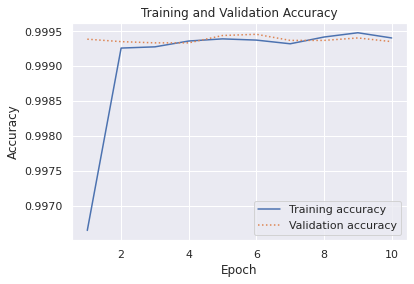

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

1781/1781 [==============================] - 4s 2ms/step


Text(89.18, 0.5, 'Actual label')

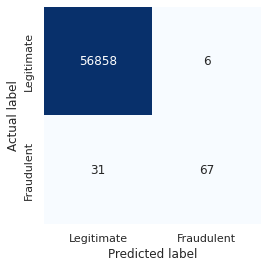

In [ ]:
from sklearn.metrics import confusion_matrix

y_predicted = model.predict(x_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['Legitimate', 'Fraudulent']

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

Task

1. Perform binary classification on the IMDB dataset. Report your accuracy after 15 epochs and draw the confusion matrix to show the error analysis.
2. Repeat 1 using a different activation function from RELU and a different optimizer.

Grading questions (in addition to any relevant ones not listed below):

1. Run your code, go through it and explain what it does.
2. Is there any part of the code that may be optimized (made better)
3. What other challenges can this solution be adapted for?
4. Will you like to discuss the time & space complexities of parts of your solution (optional)?